

# ECG Signal Denoising with Deep Learning: A Comparative Study of DRNN and FCN-DAE


### DRNN (Deep Recurrent Neural Network):

**How it Works:**
- **Encoder:** The DRNN consists of a sequence of LSTM (Long Short-Term Memory) layers in the encoder part. LSTMs are a type of recurrent neural network (RNN) that can capture long-term dependencies in sequential data.
  
- **Denoising Process:** The network is trained to learn the patterns and features of noisy ECG signals. The denoising process involves capturing the temporal dependencies within the ECG signal to distinguish between signal and noise components.

- **Decoder:** The decoded output aims to reconstruct the clean ECG signal by utilizing the learned features from the encoder. The model is trained to minimize the difference between the denoised output and the ground truth clean signal.

**How it Helps in Denoising ECG Signals:**
- **Temporal Information:** DRNNs are effective in capturing temporal dependencies in sequential data, which is crucial for ECG signals where the timing and sequence of events are significant.
  
- **Long-Term Dependencies:** LSTMs, specifically used in the encoder, can capture long-term dependencies in the ECG signal, making them suitable for denoising tasks where noise might span across multiple data points.

---

### FCN-DAE (Fully Convolutional Denoising Autoencoder):

**How it Works:**
- **Encoder:** FCN-DAE follows an architecture that utilizes convolutional layers for encoding. Convolutional layers are effective in capturing spatial hierarchies and patterns.

- **Denoising Process:** Similar to DRNN, the FCN-DAE is trained to denoise ECG signals. The convolutional layers learn hierarchical representations, capturing both local and global features in the input signal.

- **Decoder:** The decoder uses transposed convolutional layers (Conv1DTranspose) to upsample the encoded representation, aiming to reconstruct the clean ECG signal.

**How it Helps in Denoising ECG Signals:**
- **Spatial Features:** Convolutional layers are good at capturing spatial features, which is beneficial for denoising tasks where noise might manifest as local distortions or artifacts in the ECG signal.
  
- **Fully Convolutional:** The fully convolutional nature of the architecture allows for flexibility in handling signals of varying lengths, making it suitable for denoising ECG signals with different durations.


## Numerical Methods in Deep Learning for ECG Denoising

In my project, various numerical methods play a crucial role in training deep learning models for the purpose of ECG denoising. These methods encompass optimization techniques, initialization strategies, and regularization approaches that collectively contribute to the successful convergence and performance of the models. The following numerical methods are employed:

1. **Gradient Descent Optimization**
2. **Learning Rate Adjustment**
3. **Backpropagation Algorithm**
4. **Weight Initialization Strategies**
5. **Loss Function Selection**
6. **Early Stopping for Regularization**
7. **Model Checkpointing**

Each of these methods is intricately involved in the optimization process, ensuring the effective training and denoising of ECG signals through the utilization of deep learning models.

1. **Gradient Descent:**
   - *Description:* Gradient descent is an optimization algorithm used to minimize the loss function. It involves iteratively moving towards the minimum of the loss surface by adjusting model parameters in the direction opposite to the gradient.
   - *Application:* During backpropagation, the computed gradients are used to update the weights of the neural network, guiding the model towards convergence.

2. **Learning Rate Adjustment:**
   - *Description:* The learning rate is a hyperparameter that determines the step size in weight updates during gradient descent. Proper tuning of the learning rate is essential for stable and efficient convergence.
   - *Application:* The learning rate is adjusted using techniques like ReduceLROnPlateau in your project, adapting it during training based on the observed behavior of the loss.

3. **Backpropagation:**
   - *Description:* Backpropagation is a method for efficiently computing gradients of the loss function with respect to the model parameters. It involves the chain rule of calculus to propagate errors backward through the network.
   - *Application:* Gradients calculated through backpropagation are used in the weight update step of the optimization process.

4. **Weight Initialization:**
   - *Description:* Proper initialization of neural network weights is crucial for stable and effective training. Various methods, such as Glorot or He initialization, are employed to set initial weights.
   - *Application:* Appropriate weight initialization contributes to numerical stability during optimization.

5. **Loss Functions:**
   - *Description:* The choice of a loss function influences the convergence and performance of the model. Common loss functions include mean squared error (MSE) and sum of squared differences (SSD).
   - *Application:* The loss function quantifies the difference between predicted and true values, guiding the optimization process.

6. **Early Stopping:**
   - *Description:* Early stopping is a regularization technique that halts training when the performance on a validation set ceases to improve, preventing overfitting.
   - *Application:* Early stopping is implemented based on the observed behavior of validation loss during training.

7. **Model Checkpointing:**
   - *Description:* Model checkpointing saves the weights of the model during training, allowing the retrieval of the best-performing model.
   - *Application:* Model checkpoints are used to save the model weights at points of minimum validation loss.

## Importing Necessary Libraries

In [1]:
import os
from urllib.request import urlretrieve
from zipfile import ZipFile
import tensorflow as tf
import glob
import numpy as np
from scipy.signal import resample_poly
import wfdb
import math
import _pickle as pickle
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, concatenate, Activation, Input, Conv2DTranspose, Lambda, LSTM, Reshape, Embedding
import keras.backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import losses
from sklearn.model_selection import train_test_split
import pickle
from prettytable import PrettyTable
from sklearn.metrics import mean_squared_error

 - **Explanation:**
  - `os`: Operating system interface for file and directory manipulation.
  - `urlretrieve`: Function to retrieve a URL and save it locally.
  - `ZipFile`: Class to work with zip archives.
  - `tensorflow` (`tf`): An open-source machine learning library.
  - `glob`: A module for file matching using patterns.
  - `numpy` (`np`): Fundamental package for scientific computing with Python.
  - `scipy.signal.resample_poly`: Resample a signal using polyphase filtering.
  - `wfdb`: Waveform Database (WFDB) library for reading and writing PhysioNet data.
  - `math`: Standard mathematical functions.
  - `_pickle`: Module for serializing and de-serializing Python objects.
  - `matplotlib.pyplot`: Plotting library for creating visualizations.
  - `keras`: High-level neural networks API.
  - `PrettyTable`: Library for displaying tabular data in a visually appealing ASCII table.
  - `sklearn.metrics.mean_squared_error`: Function to compute mean squared error between true and predicted values.



## Data Download and Extraction

In [2]:
# Create a 'data' directory if it doesn't exist
data_dir = 'data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Download QT Database
qt_db_url = 'https://physionet.org/static/published-projects/qtdb/qt-database-1.0.0.zip'
qt_db_zip_path = os.path.join(data_dir, 'qt-database-1.0.0.zip')
urlretrieve(qt_db_url, qt_db_zip_path)

# Download MIT-BIH Noise Stress Test Database
mit_bih_url = 'https://physionet.org/static/published-projects/nstdb/mit-bih-noise-stress-test-database-1.0.0.zip'
mit_bih_zip_path = os.path.join(data_dir, 'mit-bih-noise-stress-test-database-1.0.0.zip')
urlretrieve(mit_bih_url, mit_bih_zip_path)

# Extract the downloaded zip files
with ZipFile(qt_db_zip_path, 'r') as qt_zip:
    qt_zip.extractall(data_dir)

with ZipFile(mit_bih_zip_path, 'r') as mit_bih_zip:
    mit_bih_zip.extractall(data_dir)

# Remove the zip files
os.remove(qt_db_zip_path)
os.remove(mit_bih_zip_path)

# List the contents of the 'data' directory
data_contents = os.listdir(data_dir)
print('Data directory contents:', data_contents)

print('Downloading and extracting data: Done')


Data directory contents: ['mit-bih-noise-stress-test-database-1.0.0', 'qt-database-1.0.0']


 - **Explanation:**
  - **Directory Creation**
    - Code creates a 'data' directory if it doesn't exist.
  - **Downloading QT Database**
    - Downloading the QT Database from a specified URL.
  - **Downloading MIT-BIH Noise Stress Test Database**
    - Downloading the MIT-BIH Noise Stress Test Database from a specified URL.
  - **Extracting Downloaded Zip Files**
    - Extracting the contents of the downloaded zip files using the `ZipFile` class.
  - **Cleanup - Removing Zip Files**
    - Deleting the downloaded zip files after extraction to save space.
  - **Listing Contents**
    - Listing the contents of the 'data' directory after downloading and extraction.

In [3]:
# List the contents of the 'data' directory
data_contents = os.listdir(data_dir)
print('Data directory contents:', data_contents)

print('Downloading and extracting data: Done')

Data directory contents: ['mit-bih-noise-stress-test-database-1.0.0', 'qt-database-1.0.0']


## Data Preparation

### ECG Signal

In [2]:
QTpath='data/qt-database-1.0.0/'
# Desired sampling frecuency
newFs = 360

# Preprocessing signals
namesPath = glob.glob(QTpath + "/*.dat")

# final list that will contain all signals and beats processed
QTDatabaseSignals = dict()

register_name = None
for i in namesPath:

    # reading signals
    aux = i.split('.dat')
    register_name = aux[0].split('/')[-1]
    signal, fields = wfdb.rdsamp(aux[0])
    qu = len(signal)

    # reading annotations
    ann = wfdb.rdann(aux[0], 'pu1')
    anntype = ann.symbol
    annSamples = ann.sample

    # Obtaining P wave start positions
    Anntype = np.array(anntype)
    idx = Anntype == 'p'
    Pidx = annSamples[idx]
    idxS = Anntype == '('
    Sidx = annSamples[idxS]
    idxR = Anntype == 'N'
    Ridx = annSamples[idxR]

    ind = np.zeros(len(Pidx))

    for j in range(len(Pidx)):
        arr = np.where(Pidx[j] > Sidx)
        arr = arr[0]
        ind[j] = arr[-1]

    ind = ind.astype(np.int64)
    Pstart = Sidx[ind]

    # Shift 40ms before P wave start
    Pstart = Pstart - int(0.04*fields['fs'])

    # Extract first channel
    auxSig = signal[0:qu, 0]

    # Beats separation and removing outliers
    # Beats separation and removal of the vectors that contain more or equal than
    # two beats based on QRS annotations
    beats = list()
    for k in range(len(Pstart)-1):
        remove = (Ridx > Pstart[k]) & (Ridx < Pstart[k+1])
        if np.sum(remove) < 2:
            beats.append(auxSig[Pstart[k]:Pstart[k+1]])

    # Creating the list that will contain each beat per signal
    beatsRe = list()

    # processing each beat
    for k in range(len(beats)):
        # Padding data to avoid edge effects caused by resample
        L = math.ceil(len(beats[k])*newFs/fields['fs'])
        normBeat = list(reversed(beats[k])) + list(beats[k]) + list(reversed(beats[k]))

        # resample beat by beat and saving it
        res = resample_poly(normBeat, newFs, fields['fs'])
        res = res[L-1:2*L-1]
        beatsRe.append(res)

    # storing all beats in each corresponding signal, list of list
    QTDatabaseSignals[register_name] = beatsRe

# Save Data
with open('data/QTDatabase.pkl', 'wb') as output:  # Overwrites any existing file.
    pickle.dump(QTDatabaseSignals, output)
print('=========================================================')
print('MIT QT database saved as pickle file')

MIT QT database saved as pickle file


- **Explanation:**
  - **Setting Paths and Parameters**
    - Defining the path to the QT Database and the desired sampling frequency (`newFs`).
  - **Signal Preprocessing Loop**
    - Looping through each signal in the QT Database.
      - Reading signals and annotations using the `wfdb` library.
      - Obtaining P wave start positions from annotations.
      - Shifting P wave start positions 40ms before the P wave.
      - Extracting the first channel of the signal.
      - Separating beats and removing outliers based on QRS annotations.
  - **Resampling and Data Storage**
    - Resampling each beat and storing the processed beats for each signal.
    - Saving the processed data in a dictionary (`QTDatabaseSignals`).
  - **Saving Data as Pickle File**
    - Writing the processed data into a pickle file (`QTDatabase.pkl`).

## Noise Stress Test Database (NSTDB) Processing and Saving

In [3]:
NSTDBPath = 'data/mit-bih-noise-stress-test-database-1.0.0/bw'
signals, fields = wfdb.rdsamp(NSTDBPath)

for key in fields:
    print(key, fields[key])

np.save('data/NoiseBWL', signals)

with open('data/NoiseBWL.pkl', 'wb') as output:
    pickle.dump(signals, output)
print('=========================================================')
print('MIT BIH data noise stress test database (NSTDB) saved as pickle')

fs 360
sig_len 650000
n_sig 2
base_date None
base_time None
units ['mV', 'mV']
sig_name ['noise1', 'noise2']
comments []
MIT BIH data noise stress test database (NSTDB) saved as pickle


- **Explanation:**
  - **Setting Paths and Loading Data**
    - Defining the path to the MIT-BIH Noise Stress Test Database (`NSTDBPath`).
    - Loading signals and corresponding fields using the `wfdb` library.
  - **Displaying Signal Information**
    - Printing information about the loaded signals, such as the number of signals, signal length, and other relevant fields.
  - **Saving as Numpy Array**
    - Saving the signals as a NumPy array (`NoiseBWL.npy`) using the `np.save` function.
  - **Saving Data as Pickle File**
    - Writing the loaded signals into a pickle file (`NoiseBWL.pkl`).

## Noise Stress Test Database (NSTDB) Processing and Saving (MA)

In [4]:
NSTDBPath = 'data/mit-bih-noise-stress-test-database-1.0.0/ma'
signals, fields = wfdb.rdsamp(NSTDBPath)

for key in fields:
    print(key, fields[key])

np.save('data/NoiseMA', signals)
# Save Data
with open('data/NoiseMA.pkl', 'wb') as output:
    pickle.dump(signals, output)
print('=========================================================')
print('MIT BIH data noise stress test database (NSTDB) saved as pickle')

fs 360
sig_len 650000
n_sig 2
base_date None
base_time None
units ['mV', 'mV']
sig_name ['noise1', 'noise2']
comments []
MIT BIH data noise stress test database (NSTDB) saved as pickle


 - **Explanation:**
  - **Setting Paths and Loading Data**
    - Defining the path to a specific directory in the MIT-BIH Noise Stress Test Database (`NSTDBPath`).
    - Loading signals and corresponding fields using the `wfdb` library.
  - **Displaying Signal Information**
    - Printing information about the loaded signals, such as the number of signals, signal length, and other relevant fields.
  - **Saving as Numpy Array**
    - Saving the signals as a NumPy array (`NoiseMA.npy`) using the `np.save` function.
  - **Saving Data as Pickle File**
    - Writing the loaded signals into a pickle file (`NoiseMA.pkl`).

## Noise Stress Test Database (NSTDB) Processing and Saving (EM)

In [5]:
NSTDBPath = 'data/mit-bih-noise-stress-test-database-1.0.0/em'
signals, fields = wfdb.rdsamp(NSTDBPath)

for key in fields:
    print(key, fields[key])

np.save('data/NoiseEM', signals)
# Save Data
with open('data/NoiseEM.pkl', 'wb') as output:
    pickle.dump(signals, output)
print('=========================================================')
print('MIT BIH data noise stress test database (NSTDB) saved as pickle')

fs 360
sig_len 650000
n_sig 2
base_date None
base_time None
units ['mV', 'mV']
sig_name ['noise1', 'noise2']
comments []
MIT BIH data noise stress test database (NSTDB) saved as pickle


 - **Explanation:**
  - **Setting Paths and Loading Data**
    - Defining the path to a specific directory in the MIT-BIH Noise Stress Test Database (`NSTDBPath`).
    - Loading signals and corresponding fields using the `wfdb` library.
  - **Displaying Signal Information**
    - Printing information about the loaded signals, such as the number of signals, signal length, and other relevant fields.
  - **Saving as Numpy Array**
    - Saving the signals as a NumPy array (`NoiseEM.npy`) using the `np.save` function.
  - **Saving Data as Pickle File**
    - Writing the loaded signals into a pickle file (`NoiseEM.pkl`).

## Data Preparation and Augmentation

In [6]:
print('Getting the Data ready ... ')

# The seed is used to ensure the ECG always have the same contamination level
# this enhance reproducibility
seed = 1234
np.random.seed(seed=seed)

# Load QT Database
with open('data/QTDatabase.pkl', 'rb') as input:
    # dict {register_name: beats_list}
    qtdb = pickle.load(input)

# Load NSTDB BWT
with open('data/NoiseBWL.pkl', 'rb') as input:
    nstdbwl = pickle.load(input)

# Load NSTDB MA
with open('data/NoiseMA.pkl', 'rb') as input:
    nstdma = pickle.load(input)

# Load NSTDB EN
with open('data/NoiseEM.pkl', 'rb') as input:
    nstdem = pickle.load(input)


# NSTDB

noise_channel1 = nstdbwl[:, 0]
noise_channel2 = nstdbwl[:, 1]

noise_channel3 = nstdma[:, 0]
noise_channel4 = nstdma[:, 1]

noise_channel5 = nstdem[:, 0]
noise_channel6 = nstdem[:, 1]


# Data split

noise_test_bwt = np.concatenate(
    (noise_channel1[0:int(noise_channel1.shape[0] * 0.13)], noise_channel2[0:int(noise_channel2.shape[0] * 0.13)]))
noise_train_bwt = np.concatenate((noise_channel1[int(noise_channel1.shape[0] * 0.13):-1],
                              noise_channel2[int(noise_channel2.shape[0] * 0.13):-1]))

noise_test_ma = np.concatenate(
    (noise_channel3[0:int(noise_channel3.shape[0] * 0.13)], noise_channel4[0:int(noise_channel4.shape[0] * 0.13)]))
noise_train_ma = np.concatenate((noise_channel3[int(noise_channel3.shape[0] * 0.13):-1],
                              noise_channel4[int(noise_channel4.shape[0] * 0.13):-1]))

noise_test_em = np.concatenate(
    (noise_channel5[0:int(noise_channel5.shape[0] * 0.13)], noise_channel6[0:int(noise_channel6.shape[0] * 0.13)]))
noise_train_em = np.concatenate((noise_channel5[int(noise_channel5.shape[0] * 0.13):-1],
                              noise_channel6[int(noise_channel6.shape[0] * 0.13):-1]))


# QTDatabase

beats_train = []
beats_test = []

test_set = ['qt-database-1.0.0\sel123',  # Record from MIT-BIH Arrhythmia Database
            'qt-database-1.0.0\sel233',  # Record from MIT-BIH Arrhythmia Database

            'qt-database-1.0.0\sel302',  # Record from MIT-BIH ST Change Database
            'qt-database-1.0.0\sel307',  # Record from MIT-BIH ST Change Database

            'qt-database-1.0.0\sel820',  # Record from MIT-BIH Supraventricular Arrhythmia Database
            'qt-database-1.0.0\sel853',  # Record from MIT-BIH Supraventricular Arrhythmia Database

            'qt-database-1.0.0\sel16420',  # Record from MIT-BIH Normal Sinus Rhythm Database
            'qt-database-1.0.0\sel16795',  # Record from MIT-BIH Normal Sinus Rhythm Database

            'qt-database-1.0.0\sele0106',  # Record from European ST-T Database
            'qt-database-1.0.0\sele0121',  # Record from European ST-T Database

            'qt-database-1.0.0\sel32',  # Record from ``sudden death'' patients from BIH
            'qt-database-1.0.0\sel49',  # Record from ``sudden death'' patients from BIH

            'qt-database-1.0.0\sel14046',  # Record from MIT-BIH Long-Term ECG Database
            'qt-database-1.0.0\sel15814',  # Record from MIT-BIH Long-Term ECG Database
            ]

# Creating the train and test dataset, each datapoint has 512 samples and is zero padded
# beats bigger that 512 samples are discarded to avoid wrong split beats ans to reduce
# computation.
skip_beats = 0
samples = 512
qtdb_keys = list(qtdb.keys())

for i in range(len(qtdb_keys)):
    signal_name = qtdb_keys[i]

    for b in qtdb[signal_name]:

        b_np = np.zeros(samples)
        b_sq = np.array(b)

        # There are beats with more than 512 samples (could be up to 3500 samples)
        # Creating a threshold of 512 - init_padding samples max. gives a good compromise between
        # the samples amount and the discarded signals amount
        # before:
        # train: 74448  test: 13362
        # after:
        # train: 71893 test: 13306  (discarded train: ~4k datapoints test: ~50)

        init_padding = 16
        if b_sq.shape[0] > (samples - init_padding):
            skip_beats += 1
            continue

        b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

        if signal_name in test_set:
            beats_test.append(b_np)
        else:
            beats_train.append(b_np)

# Noise was added in a proportion from 0.2 to 2 times the ECG signal amplitude
# Similar to
# W. Muldrow, R.G. Mark, & Moody, G. B. (1984).
# A noise stress test for arrhythmia detectors.
# Computers in Cardiology, 381–384

sn_train = []
sn_test = []

noise_index = 0

# Adding noise to train
rnd_train = np.random.randint(low=20, high=200, size=len(beats_train)) / 100
for i in range(len(beats_train)):
    beat_max_value = np.max(beats_train[i]) - np.min(beats_train[i])

    noise_bwt = noise_train_bwt[noise_index:noise_index + samples]
    noise_max_value_bwt = np.max(noise_bwt) - np.min(noise_bwt)
    Ase_bwt = noise_max_value_bwt / beat_max_value
    alpha = rnd_train[i] / Ase_bwt

    noise_ma = noise_train_ma[noise_index:noise_index + samples]
    noise_max_value_ma = np.max(noise_ma) - np.min(noise_ma)
    Ase_ma = noise_max_value_ma / beat_max_value
    beta = rnd_train[i] / Ase_ma

    noise_em = noise_train_bwt[noise_index:noise_index + samples]
    noise_max_value_em = np.max(noise_em) - np.min(noise_em)
    Ase_em = noise_max_value_em / beat_max_value
    gamma = rnd_train[i] / Ase_em

    signal_noise = beats_train[i] + alpha/3 * noise_bwt + beta/3 * noise_ma + gamma/3 * noise_em

    sn_train.append(signal_noise)
    noise_index += samples

    if noise_index > (len(noise_train_bwt) - samples):
        noise_index = 0

# Adding noise to test
noise_index = 0
rnd_test = np.random.randint(low=20, high=200, size=len(beats_test)) / 100
for i in range(len(beats_test)):
    beat_max_value = np.max(beats_test[i]) - np.min(beats_test[i])

    noise_bwt = noise_test_bwt[noise_index:noise_index + samples]
    noise_max_value_bwt = np.max(noise_bwt) - np.min(noise_bwt)
    Ase_bwt = noise_max_value_bwt / beat_max_value
    alpha = rnd_test[i] / Ase_bwt

    noise_ma = noise_test_ma[noise_index:noise_index + samples]
    noise_max_value_ma = np.max(noise_ma) - np.min(noise_ma)
    Ase_ma = noise_max_value_ma / beat_max_value
    beta = rnd_test[i] / Ase_ma

    noise_em = noise_test_bwt[noise_index:noise_index + samples]
    noise_max_value_em = np.max(noise_em) - np.min(noise_em)
    Ase_em = noise_max_value_em / beat_max_value
    gamma = rnd_test[i] / Ase_em

    signal_noise = beats_test[i] + alpha/3 * noise_bwt + beta/3 * noise_ma + gamma/3 * noise_em

    sn_test.append(signal_noise)
    noise_index += samples

    if noise_index > (len(noise_test_bwt) - samples):
        noise_index = 0

# X_train = np.array(sn_train)
# y_train = np.array(beats_train)

# X_test = np.array(sn_test)
# y_test = np.array(beats_test)

# X_train = np.expand_dims(X_train, axis=2)
# y_train = np.expand_dims(y_train, axis=2)

# X_test = np.expand_dims(X_test, axis=2)
# y_test = np.expand_dims(y_test, axis=2)

# Dataset = [X_train, y_train, X_test, y_test]
# print('Dataset ready to use.')

X_train = np.array(sn_train)
y_train = np.array(beats_train)

X_test = np.array(sn_test)
y_test = np.array(beats_test)

# data is initially in the shape (batch_size, sequence_length)
X_train = np.expand_dims(X_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)

X_test = np.expand_dims(X_test, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

Dataset = [X_train, y_train, X_test, y_test]

print('Dataset ready to use.')

Getting the Data ready ... 
Dataset ready to use.


 - **Explanation:**
  - **Loading Datasets**
    - Loading the QT Database and various subsets of the MIT-BIH Noise Stress Test Database.
  - **Signal and Noise Splitting**
    - Extracting noise channels from the MIT-BIH Noise Stress Test Database.
    - Splitting noise channels into different subsets.
  - **Splitting Training and Testing Data**
    - Dividing noise signals into training and testing sets based on a specified proportion.
    - Extracting beats from the QT Database and separating them into training and testing sets.
  - **Adding Noise to Signals**
    - Adding noise to the training and testing beats from the QT Database.
    - The noise is generated based on different subsets of the MIT-BIH Noise Stress Test Database.
  - **Data Formatting**
    - Converting the generated signals and noise into appropriate NumPy arrays.
    - Reshaping the data to be compatible with neural network input requirements.
  - **Dataset Compilation**
    - Creating a dataset ready for training and testing.

In [25]:
print("DATASET SHAPE")
print(f'Training {X_train.shape}')
print(f'Testing {X_test.shape}')

DATASET SHAPE
Training (72002, 512, 1)
Testing (13316, 512, 1)


In [8]:
print("Size of beats_test:", len(beats_test))
print("Size of sn_test:", len(sn_test))


Size of beats_test: 13316
Size of sn_test: 13316


In [9]:
print("Test Set Signal Names:", test_set)


Test Set Signal Names: ['qt-database-1.0.0\\sel123', 'qt-database-1.0.0\\sel233', 'qt-database-1.0.0\\sel302', 'qt-database-1.0.0\\sel307', 'qt-database-1.0.0\\sel820', 'qt-database-1.0.0\\sel853', 'qt-database-1.0.0\\sel16420', 'qt-database-1.0.0\\sel16795', 'qt-database-1.0.0\\sele0106', 'qt-database-1.0.0\\sele0121', 'qt-database-1.0.0\\sel32', 'qt-database-1.0.0\\sel49', 'qt-database-1.0.0\\sel14046', 'qt-database-1.0.0\\sel15814']


In [10]:
for i in range(len(qtdb_keys)):
    signal_name = qtdb_keys[i]
    print("Processing signal:", signal_name)


Processing signal: qt-database-1.0.0\sel100
Processing signal: qt-database-1.0.0\sel102
Processing signal: qt-database-1.0.0\sel103
Processing signal: qt-database-1.0.0\sel104
Processing signal: qt-database-1.0.0\sel114
Processing signal: qt-database-1.0.0\sel116
Processing signal: qt-database-1.0.0\sel117
Processing signal: qt-database-1.0.0\sel123
Processing signal: qt-database-1.0.0\sel14046
Processing signal: qt-database-1.0.0\sel14157
Processing signal: qt-database-1.0.0\sel14172
Processing signal: qt-database-1.0.0\sel15814
Processing signal: qt-database-1.0.0\sel16265
Processing signal: qt-database-1.0.0\sel16272
Processing signal: qt-database-1.0.0\sel16273
Processing signal: qt-database-1.0.0\sel16420
Processing signal: qt-database-1.0.0\sel16483
Processing signal: qt-database-1.0.0\sel16539
Processing signal: qt-database-1.0.0\sel16773
Processing signal: qt-database-1.0.0\sel16786
Processing signal: qt-database-1.0.0\sel16795
Processing signal: qt-database-1.0.0\sel17152
Proc

## Model Architectures


In [11]:
def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, activation='relu', padding='same'):
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters,
                        kernel_size=(kernel_size, 1),
                        activation=activation,
                        strides=(strides, 1),
                        padding=padding)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x


def FCN_DAE():
    # Implementation of FCN_DAE approach presented in
    # Chiang, H. T., Hsieh, Y. Y., Fu, S. W., Hung, K. H., Tsao, Y., & Chien, S. Y. (2019).
    # Noise reduction in ECG signals using fully convolutional denoising autoencoders.
    # IEEE Access, 7, 60806-60813.

    input_shape = (512, 1)
    input = Input(shape=input_shape)

    # Encoder
    x = Conv1D(filters=40,
               input_shape=(512, 1),
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(input)

    x = BatchNormalization()(x)

    x = Conv1D(filters=20,
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(x)

    x = BatchNormalization()(x)

    x = Conv1D(filters=20,
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(x)

    x = BatchNormalization()(x)

    x = Conv1D(filters=20,
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(x)

    x = BatchNormalization()(x)

    x = Conv1D(filters=40,
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(x)

    x = BatchNormalization()(x)

    x = Conv1D(filters=1,
               kernel_size=16,
               activation='elu',
               strides=1,
               padding='same')(x)

    x = BatchNormalization()(x)

    # Decoder
    x = Conv1DTranspose(input_tensor=x,
                        filters=1,
                        kernel_size=16,
                        activation='elu',
                        strides=1,
                        padding='same')

    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=40,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=20,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=20,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=20,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=40,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)

    predictions = Conv1DTranspose(input_tensor=x,
                        filters=1,
                        kernel_size=16,
                        activation='linear',
                        strides=1,
                        padding='same')

    model = Model(inputs=[input], outputs=predictions)
    return model


def DRRN_denoising():
    # Implementation of DRNN approach presented in
    # Antczak, K. (2018). Deep recurrent neural networks for ECG signal denoising.
    # arXiv preprint arXiv:1807.11551.    

    model = Sequential()
    model.add(LSTM(64, input_shape=(512, 1), return_sequences=True))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))

    return model

#### Function 1: `Conv1DTranspose`

- **Explanation:**
  - Custom function to implement 1D Transpose Convolution.
  - Utilizes Lambda layers to expand and squeeze dimensions.
  - Takes an input tensor, number of filters, kernel size, strides, activation function, and padding as parameters.
  - Returns the transposed convolution result.

#### Function 2: `FCN_DAE`

- **Explanation:**
  - Implementation of the FCN_DAE (Fully Convolutional Denoising Autoencoder) approach.
  - Architecture based on the paper by Chiang et al. (2019) for noise reduction in ECG signals.
  - Input shape is set to (512, 1).
  - Consists of an encoder with convolutional layers, batch normalization, and an autoencoder-style decoder.
  - The final layer uses linear activation for regression.

#### Function 3: `DRRN_denoising`

- **Explanation:**
  - Implementation of the DRNN (Deep Recurrent Neural Network) approach for ECG signal denoising.
  - Architecture based on the paper by Antczak (2018).
  - Utilizes an LSTM layer with 64 units followed by dense layers with ReLU activation.
  - The final layer uses linear activation for regression.

These functions define the neural network architectures for denoising ECG signals based on the specified approaches. The models can be instantiated and further trained using the prepared datasets.

## Deep Learning Training and Testing Functions


In [15]:
def ssd_loss(y_true, y_pred):
    return K.sum(K.square(y_pred - y_true), axis=-2)


def train_dl(Dataset, experiment):

    print('Deep Learning pipeline: Training the model for exp ' + str(experiment))

    [X_train, y_train, X_test, y_test] = Dataset

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, random_state=1)

    if experiment == 'FCN-DAE':
        # FCN_DAE
        model = FCN_DAE()
        model_label = 'FCN_DAE'
        criterion = ssd_loss

    if experiment == 'DRNN':
        # DRNN
        model = DRRN_denoising()
        model_label = 'DRNN'
        criterion = keras.losses.mean_squared_error

    print('\n ' + model_label + '\n ')

    model.summary()

    epochs = 50
    batch_size = 350
    lr = 1e-3
    minimum_lr = 1e-10

    model.compile(loss=criterion,
                  optimizer=keras.optimizers.Adam(lr=lr),
                  metrics=[losses.mean_squared_error, ssd_loss])

    # checkpoint
    model_filepath = model_label + '_weights.best.hdf5'

    checkpoint = ModelCheckpoint(model_filepath,
                                 monitor="val_loss",
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min', 
                                 save_weights_only=True)
    
    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.5,
                                  min_delta=0.05,
                                  mode='min',
                                  patience=2,
                                  min_lr=minimum_lr,
                                  verbose=1)
    
    early_stop = EarlyStopping(monitor="val_loss", 
                               min_delta=0.05,
                               mode='min', 
                               patience=10,
                               verbose=1)

    # Train the model and get the training history
    history = model.fit(x=X_train, y=y_train,
                        validation_data=(X_val, y_val),
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        callbacks=[checkpoint, reduce_lr, early_stop])

    # Plot performance metrics over time
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Over Epochs')
    plt.show()

    K.clear_session()



def test_dl(Dataset, experiment):

    print('Deep Learning pipeline: Testing the model')

    [train_set, train_set_GT, X_test, y_test] = Dataset

    batch_size = 128

    if experiment == 'FCN-DAE':
        # FCN_DAE
        model = FCN_DAE()
        model_label = 'FCN_DAE'
        criterion = ssd_loss

    if experiment == 'DRNN':
        # DRNN
        model = DRRN_denoising()
        model_label = 'DRNN'
        criterion = keras.losses.mean_squared_error

    print('\n ' + model_label + '\n ')

    model.summary()

    model.compile(loss=criterion,
                  optimizer=keras.optimizers.Adam(lr=0.01),
                  metrics=[keras.losses.mean_squared_error, ssd_loss])

    # checkpoint
    model_filepath = model_label + '_weights.best.hdf5'
    # load weights
    model.load_weights(model_filepath)

    # Test score
    y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)

    # Plot performance metrics for testing
    plt.figure(figsize=(8, 4))
    plt.plot(y_test[0], label='True Signal')
    plt.plot(y_pred[0], label='Denoised Signal')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude [mV]')
    plt.legend()
    plt.title('Denoised Signal vs True Signal')
    plt.show()

    K.clear_session()

    return [X_test, y_test, y_pred]


#### Function 1: `ssd_loss`

- **Explanation:**
  - Custom loss function for Sum of Squared Differences (SSD).
  - Computes the sum of squared differences between predicted and true values along the second-to-last axis.

#### Function 2: `train_dl`

- **Explanation:**
  - Training function for deep learning models.
  - Takes the prepared dataset and an experiment label as input.
  - Instantiates the selected model (FCN_DAE or DRNN) and compiles it with a specified loss function, optimizer, and metrics.
  - Trains the model using the training dataset with callbacks for checkpointing, learning rate reduction, and early stopping.

#### Function 3: `test_dl`

- **Explanation:**
  - Testing function for deep learning models.
  - Takes the test dataset and an experiment label as input.
  - Instantiates the selected model (FCN_DAE or DRNN) and compiles it with the same configuration used during training.
  - Loads the best weights obtained during training using the checkpoint mechanism.
  - Performs predictions on the test dataset and returns the input signals, true labels, and predicted labels.

These functions provide the pipeline for training and testing deep learning models for ECG signal denoising based on the specified experiments (FCN_DAE or DRNN). The models are trained and evaluated using the provided datasets.

### Deep Learning Experiments List

- **Explanation:**
  - The list `dl_experiments` contains the labels for different deep learning experiments.
  - Available experiments include 'DRNN' and 'FCN-DAE'.
  - These labels are used to specify which model to train and test during the deep learning pipeline.

In [16]:
dl_experiments = ['DRNN',
                  'FCN-DAE'
                  ]

## Deep Learning Experiments Execution and Results Saving

- **Explanation:**
  - The code iterates through each experiment specified in `dl_experiments`.
  - For each experiment, it trains a deep learning model using the `train_dl` function and then tests the model using the `test_dl` function.
  - The results, including input signals, true labels, and predicted labels, are saved as a pickle file named `test_results_experiment_label.pkl`.
  - A message is printed indicating the completion of each experiment.

In [17]:
for experiment in range(len(dl_experiments)):
    train_dl(Dataset, dl_experiments[experiment])

    [X_test, y_test, y_pred] = test_dl(Dataset, dl_experiments[experiment])

    test_results = [X_test, y_test, y_pred]

    # Save Results
    with open('test_results_' + dl_experiments[experiment] + '.pkl', 'wb') as output: 
        pickle.dump(test_results, output)

    print('Results from experiment ' + dl_experiments[experiment] + ' saved')

Deep Learning pipeline: Training the model for exp DRNN

 DRNN
 
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 512, 64)           16896     
                                                                 
 dense_3 (Dense)             (None, 512, 64)           4160      
                                                                 
 dense_4 (Dense)             (None, 512, 64)           4160      
                                                                 
 dense_5 (Dense)             (None, 512, 1)            65        
                                                                 
Total params: 25281 (98.75 KB)
Trainable params: 25281 (98.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50
145/145 [==============================] - ETA: 0s - loss: 0.0491 - mean_squared_error: 0.0491 - ssd_loss: 25.1457
Epoch 1: val_loss improved from inf to 0.03853, saving model to DRNN_weights.best.hdf5
145/145 [==============================] - 245s 2s/step - loss: 0.0491 - mean_squared_error: 0.0491 - ssd_loss: 25.1457 - val_loss: 0.0385 - val_mean_squared_error: 0.0385 - val_ssd_loss: 19.7292 - lr: 0.0010
Epoch 2/50
145/145 [==============================] - ETA: 0s - loss: 0.0345 - mean_squared_error: 0.0345 - ssd_loss: 17.6482
Epoch 2: val_loss improved from 0.03853 to 0.03171, saving model to DRNN_weights.best.hdf5
145/145 [==============================] - 251s 2s/step - loss: 0.0345 - mean_squared_error: 0.0345 - ssd_loss: 17.6482 - val_loss: 0.0317 - val_mean_squared_error: 0.0317 - val_ssd_loss: 16.2364 - lr: 0.0010
Epoch 3/50
145/145 [==============================] - ETA: 0s - loss: 0.0354 - mean_squared_error: 0.0354 - ssd_loss: 18.1498
Epoch 3: val_loss did not 

105/105 [==============================] - 26s 246ms/step
Results from experiment DRNN saved
Deep Learning pipeline: Training the model for exp FCN-DAE

 FCN_DAE
 
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 256, 40)           680       
                                                                 
 batch_normalization (Batch  (None, 256, 40)           160       
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 128, 20)           12820     
                                                                 
 batch_normalization_1 (Bat  (None, 128, 20)           80        
 chNormalization)            

Epoch 1/50
145/145 [==============================] - ETA: 0s - loss: 54.2675 - mean_squared_error: 0.1060 - ssd_loss: 54.2675
Epoch 1: val_loss improved from inf to 37.07221, saving model to FCN_DAE_weights.best.hdf5
145/145 [==============================] - 143s 939ms/step - loss: 54.2675 - mean_squared_error: 0.1060 - ssd_loss: 54.2675 - val_loss: 37.0722 - val_mean_squared_error: 0.0724 - val_ssd_loss: 37.0722 - lr: 0.0010
Epoch 2/50
144/145 [============================>.] - ETA: 0s - loss: 26.6442 - mean_squared_error: 0.0520 - ssd_loss: 26.6442
Epoch 2: val_loss did not improve from 37.07221
145/145 [==============================] - 116s 798ms/step - loss: 26.6444 - mean_squared_error: 0.0520 - ssd_loss: 26.6444 - val_loss: 39.0176 - val_mean_squared_error: 0.0762 - val_ssd_loss: 39.0176 - lr: 0.0010
Epoch 3/50
144/145 [============================>.] - ETA: 0s - loss: 20.0573 - mean_squared_error: 0.0392 - ssd_loss: 20.0573
Epoch 3: val_loss improved from 37.07221 to 26.45308

Epoch 39/50
144/145 [============================>.] - ETA: 0s - loss: 5.0401 - mean_squared_error: 0.0098 - ssd_loss: 5.0401
Epoch 39: val_loss improved from 5.03980 to 5.03297, saving model to FCN_DAE_weights.best.hdf5
145/145 [==============================] - 117s 811ms/step - loss: 5.0402 - mean_squared_error: 0.0098 - ssd_loss: 5.0402 - val_loss: 5.0330 - val_mean_squared_error: 0.0098 - val_ssd_loss: 5.0330 - lr: 3.9063e-06
Epoch 40/50
144/145 [============================>.] - ETA: 0s - loss: 5.0277 - mean_squared_error: 0.0098 - ssd_loss: 5.0277
Epoch 40: val_loss did not improve from 5.03297

Epoch 40: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
145/145 [==============================] - 119s 819ms/step - loss: 5.0278 - mean_squared_error: 0.0098 - ssd_loss: 5.0278 - val_loss: 5.0408 - val_mean_squared_error: 0.0098 - val_ssd_loss: 5.0408 - lr: 3.9063e-06
Epoch 41/50
144/145 [============================>.] - ETA: 0s - loss: 5.0338 - mean_squared_error

                                                                 
 conv2d_transpose_2 (Conv2D  (None, 64, 1, 20)         12820     
 Transpose)                                                      
                                                                 
 lambda_5 (Lambda)           (None, 64, 20)            0         
                                                                 
 batch_normalization_8 (Bat  (None, 64, 20)            80        
 chNormalization)                                                
                                                                 
 lambda_6 (Lambda)           (None, 64, 1, 20)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 128, 1, 20)        6420      
 Transpose)                                                      
                                                                 
 lambda_7 (Lambda)           (None, 128, 20)           0         
          

105/105 [==============================] - 8s 74ms/step
Results from experiment FCN-DAE saved


## Evaluation Metrics Functions


In [18]:

def SSD(y, y_pred):
    return np.sum(np.square(y - y_pred), axis=1)

def MAD(y, y_pred):
    return np.max(np.abs(y - y_pred), axis=1)

def RMSE(y, y_pred):
    return np.sqrt(np.mean(np.sum(np.square(y - y_pred), axis=1), axis = 1))


#### Function 1: `SSD`

- **Explanation:**
  - Calculates the Sum of Squared Differences (SSD) between the true and predicted values along the specified axis.

#### Function 2: `MAD`

- **Explanation:**
  - Calculates the Maximum Absolute Deviation (MAD) between the true and predicted values along the specified axis.

#### Function 3: `RMSE`

- **Explanation:**
  - Calculates the Root Mean Squared Error (RMSE) between the true and predicted values along the specified axis.

These functions provide different evaluation metrics for assessing the performance of the deep learning models. They take the true labels (`y`) and predicted labels (`y_pred`) as input and return the corresponding metric values.

## Table Generation Function


In [19]:


def generate_table(metrics, metric_values, Exp_names):
    # Print tabular results in the console, in a pretty way
    print('\n')

    tb = PrettyTable()
    ind = 0

    for exp_name in Exp_names:

        tb.field_names = ['Method/Model'] + metrics

        tb_row = []
        tb_row.append(exp_name)

        for metric in metric_values:
            m_mean = np.mean(metric[ind])
            m_std = np.std(metric[ind])
            tb_row.append('{:.3f}'.format(m_mean) + ' (' + '{:.3f}'.format(m_std) + ')')

        tb.add_row(tb_row)
        ind += 1

    print(tb)


- **Explanation:**
  - The function `generate_table` is designed to print tabular results in a formatted manner in the console.
  - It takes three parameters: `metrics` (list of metric names), `metric_values` (list of metric values for each experiment), and `Exp_names` (list of experiment names).
  - The function uses the PrettyTable library to create a table with columns for each metric and rows for each experiment.
  - For each metric and experiment, it calculates the mean and standard deviation of the metric values and prints them in the table.

This function provides a convenient way to display the evaluation results of different experiments in a tabular format.

## Results Loading and Metrics Calculation

- **Explanation:**
  - The code loads the results of the deep learning experiments (DRNN and FCN_DAE) from the saved pickle files.
  - It then calculates evaluation metrics (SSD, MAD, RMSE) for each experiment based on the true and predicted labels.
  - The results are stored in arrays for further analysis and comparison.

### Note:
- The provided code assumes that the pickle files (`test_results_DRNN.pkl` and `test_results_FCN_DAE.pkl`) exist in the current working directory. Make sure to adjust the file paths if they are stored in a different location.

In [20]:
# Load Results DRNN
with open('test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)

# Load Results FCN_DAE
with open('test_results_' + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)



####### Calculate Metrics #######

print('Calculating metrics ...')

# DL Metrics

# Exp FCN-DAE

[X_test, y_test, y_pred] = test_DRNN

SSD_values_DL_DRNN = SSD(y_test, y_pred)

MAD_values_DL_DRNN = MAD(y_test, y_pred)

RMSE_values_DL_DRNN = RMSE(y_test, y_pred)

# Exp FCN-DAE

[X_test, y_test, y_pred] = test_FCN_DAE

SSD_values_DL_FCN_DAE = SSD(y_test, y_pred)

MAD_values_DL_FCN_DAE = MAD(y_test, y_pred)

RMSE_values_DL_FCN_DAE = RMSE(y_test, y_pred)

SSD_all = [SSD_values_DL_DRNN,
           SSD_values_DL_FCN_DAE,
           
           ]

MAD_all = [
           MAD_values_DL_DRNN,
           MAD_values_DL_FCN_DAE,
           
           ]

RMSE_all = [
            RMSE_values_DL_DRNN,
            RMSE_values_DL_FCN_DAE,
            ]

metrics = ['SSD', 'MAD', 'RMSE']
metric_values = [SSD_all, MAD_all, RMSE_all]

# Metrics table
generate_table(metrics, metric_values, dl_experiments)


Calculating metrics ...


+--------------+-----------------+---------------+---------------+
| Method/Model |       SSD       |      MAD      |      RMSE     |
+--------------+-----------------+---------------+---------------+
|     DRNN     | 11.027 (11.137) | 0.684 (0.372) | 3.003 (1.418) |
|   FCN-DAE    |  5.865 (7.121)  | 0.567 (0.354) | 2.166 (1.084) |
+--------------+-----------------+---------------+---------------+


**Results Table**:

| Method/Model |      SSD      |     MAD      |     RMSE     |
|--------------|---------------|--------------|--------------|
|     DRNN     | 11.027 (11.137) | 0.684 (0.372) | 3.003 (1.418) |
|   FCN-DAE    |  5.865 (7.121)  | 0.567 (0.354) | 2.166 (1.084) |

The table displays the mean and standard deviation values of the evaluation metrics (SSD, MAD, RMSE) for the DRNN and FCN-DAE models. These metrics provide insights into the performance of each model in denoising ECG signals, with lower values indicating better performance.

## Results Extraction

- **Explanation:**
  - The code extracts the test data (`X_test`), true labels (`y_test`), and predicted labels (`y_pred`) for both the DRNN and FCN_DAE models.
  - This allows for further analysis or visualization of specific test cases and predictions.

In [21]:
[X_test_1, y_test_1, y_pred_1] = test_DRNN
[X_test_2, y_test_2, y_pred_2] = test_FCN_DAE

## Visualization of Denoising Results

- **Explanation:**
  - The code plots the denoising results for a specific test case (index 3390) from the DRNN and FCN-DAE models.
  - It visualizes the original ECG signal with added noise, the ground truth ECG signal, and the denoised signals produced by both models.
  - The x-axis represents the samples, and the y-axis represents the amplitude in millivolts (mV).
  - The legend indicates the type of signals displayed in the plot.

### Note:
- You can adjust the test case index (`3390`) or customize the plot as needed for specific analysis.

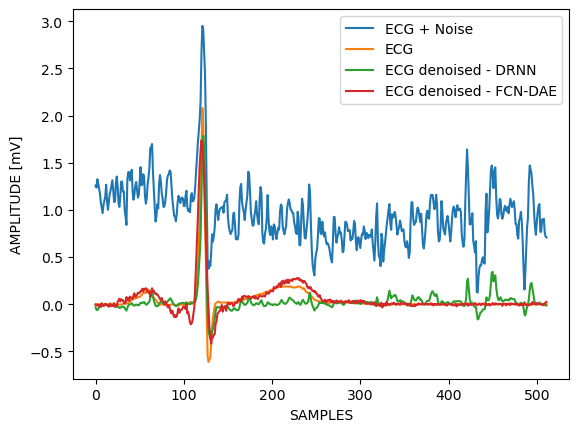

In [22]:
plt.plot(X_test_1[3390], label="ECG + Noise")
plt.plot(y_test_1[3390], label="ECG")
plt.plot(y_pred_1[3390], label="ECG denoised - DRNN")
plt.plot(y_pred_2[3390], label="ECG denoised - FCN-DAE")
plt.xlabel("SAMPLES")
plt.ylabel("AMPLITUDE [mV]")
plt.legend()
plt.show()

## Randomized Visualization of Denoising Results

- **Explanation:**
  - The code randomly selects 50 test cases and plots the denoising results for each case.
  - For each test case, it shows the original ECG signal with added noise, the ground truth ECG signal, and the denoised signals produced by both the DRNN and FCN-DAE models.
  - The x-axis represents the samples, and the y-axis represents the amplitude in millivolts (mV).
  - The legend indicates the type of signals displayed in each plot.

### Note:
- This randomized visualization provides an overview of the denoising performance across different test cases. Adjust the number of cases or customize the plot as needed for specific analysis .

12417


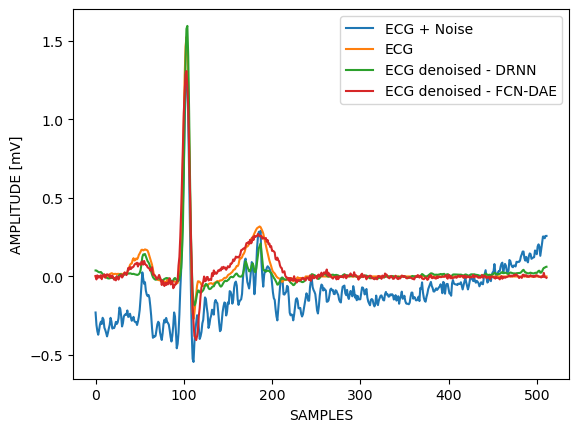

9221


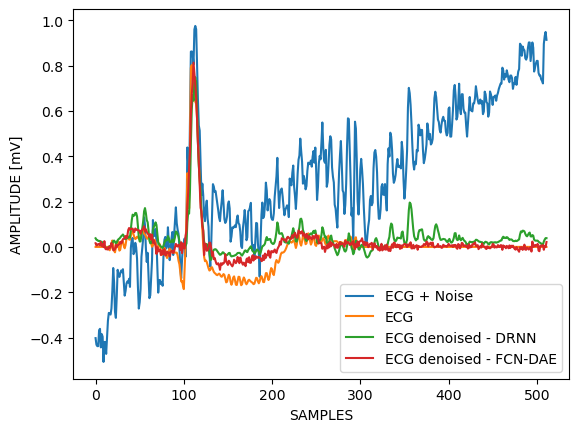

3323


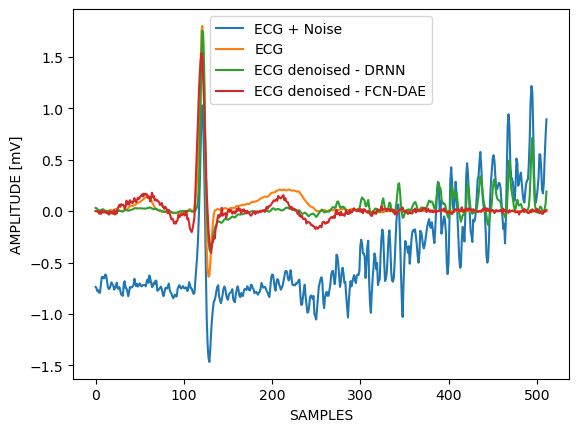

7738


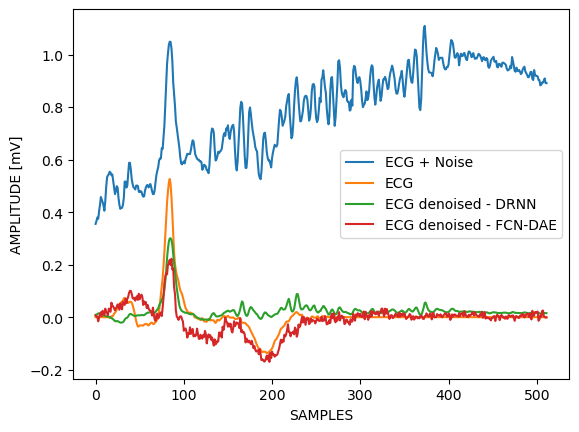

10146


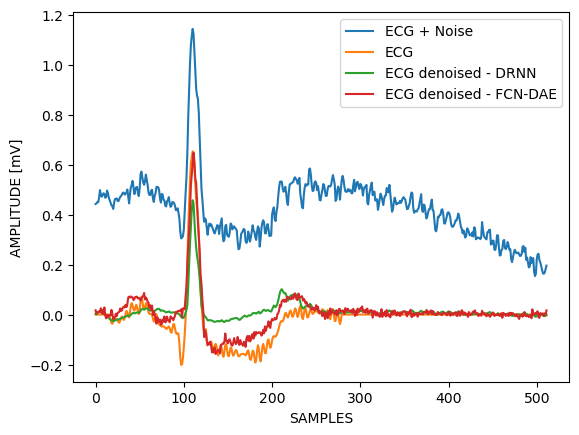

1444


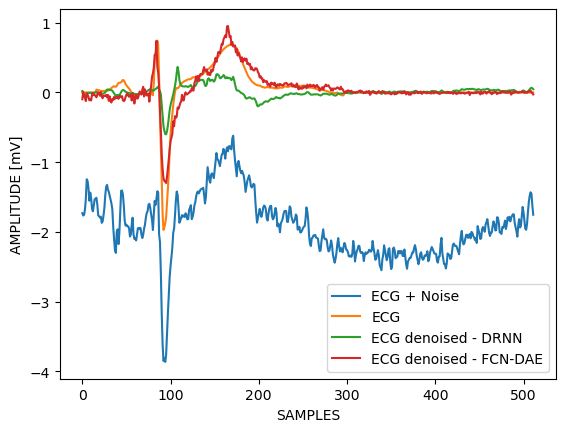

7500


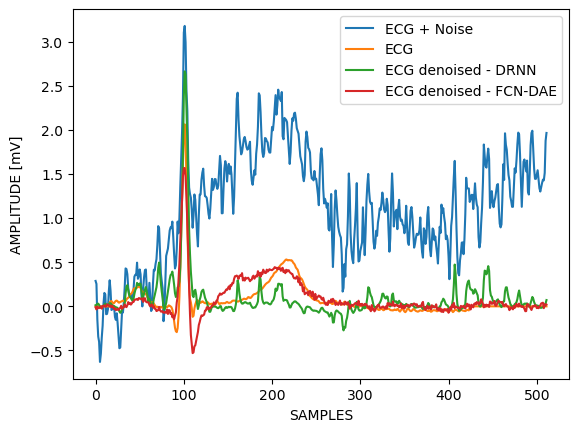

1554


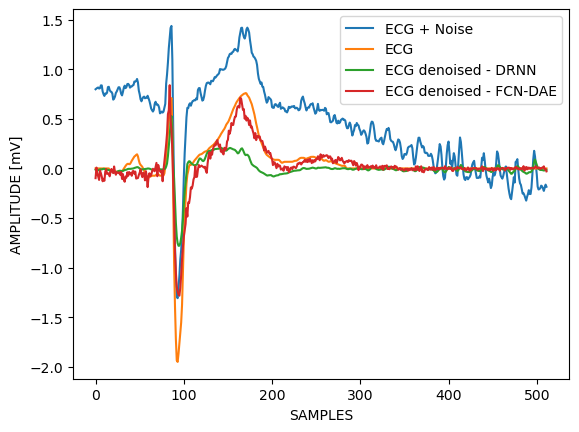

4804


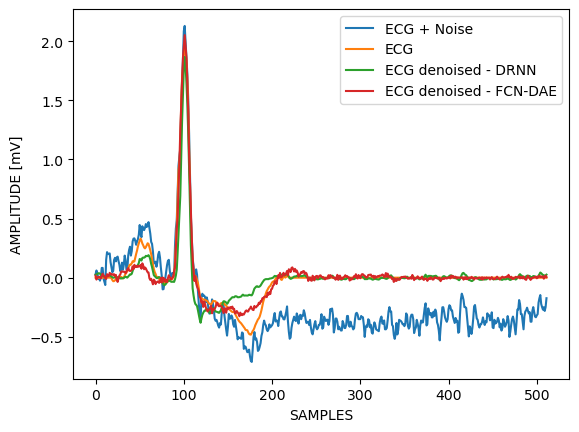

3188


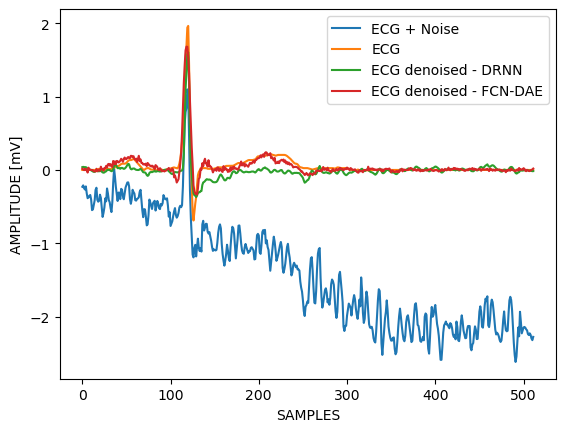

2066


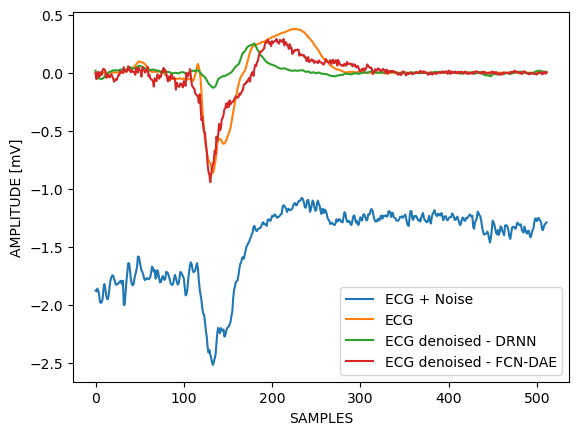

9697


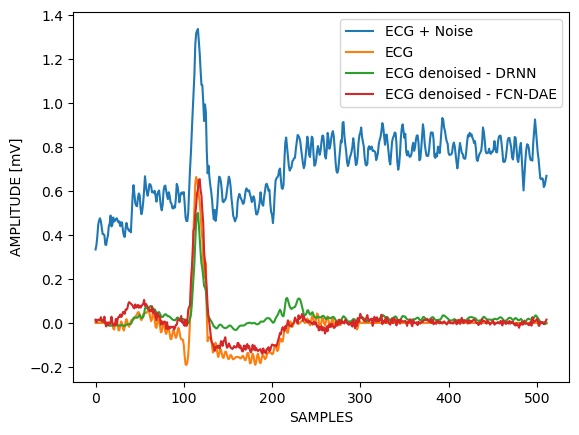

8541


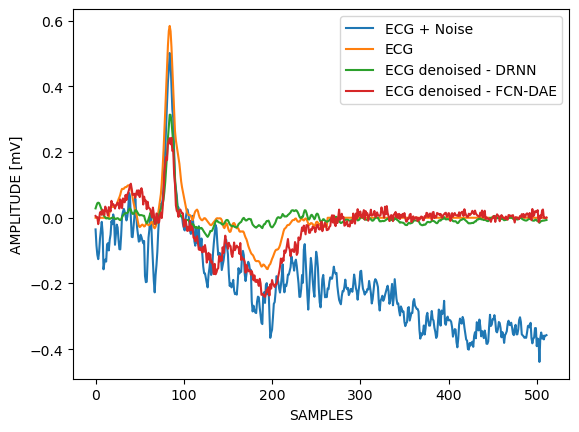

1800


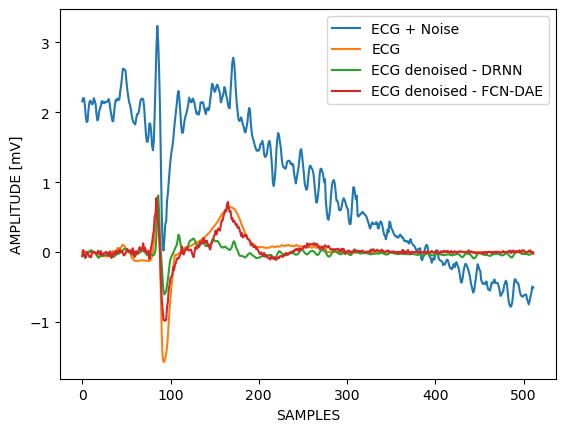

2884


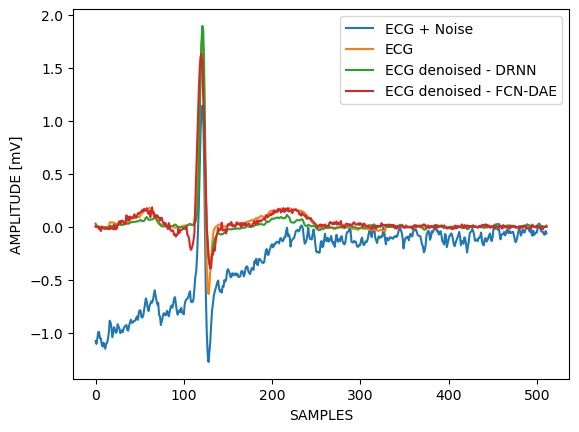

5941


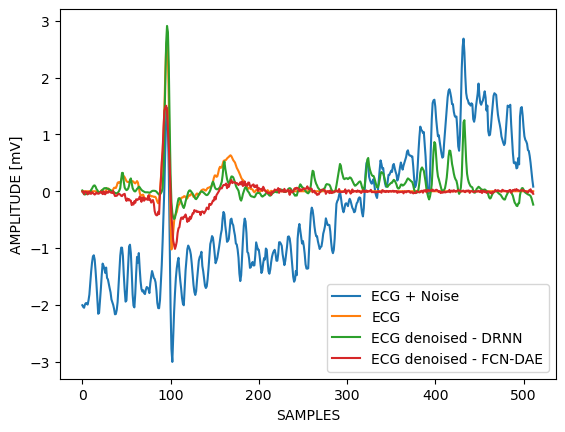

2379


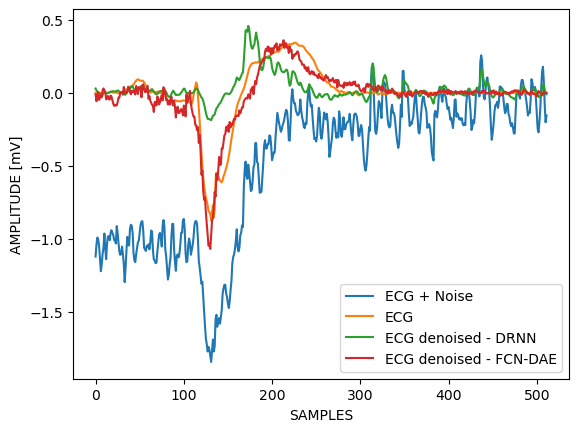

3460


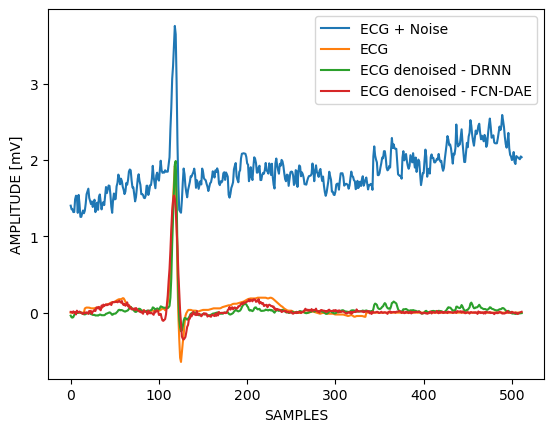

3103


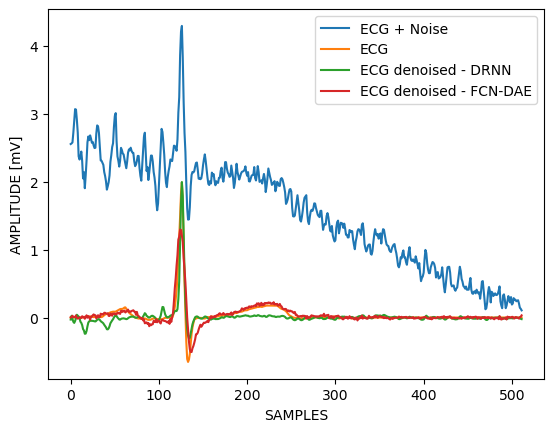

7575


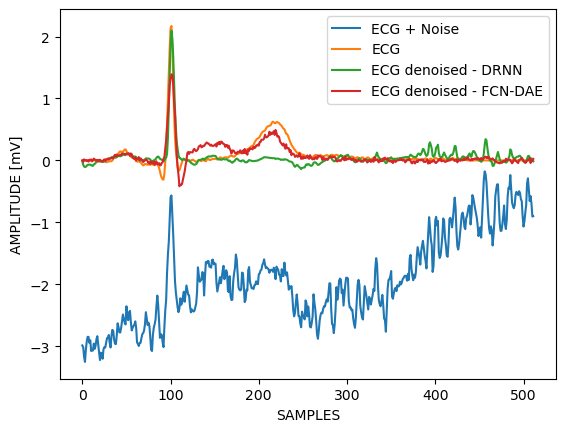

6885


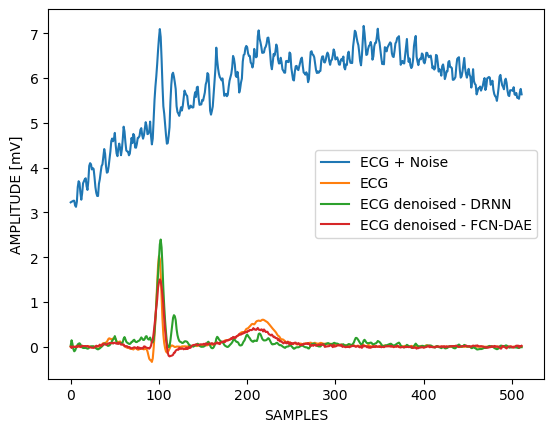

245


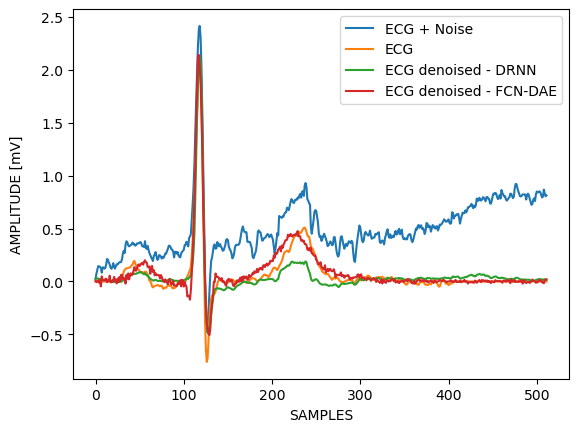

3547


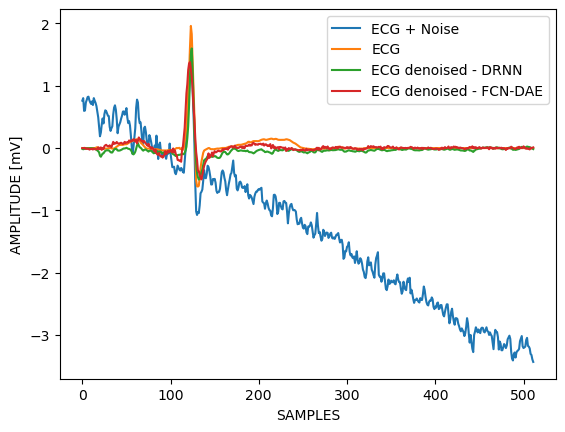

1838


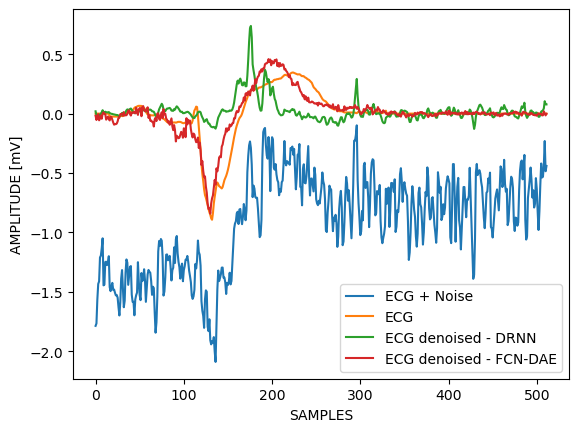

11854


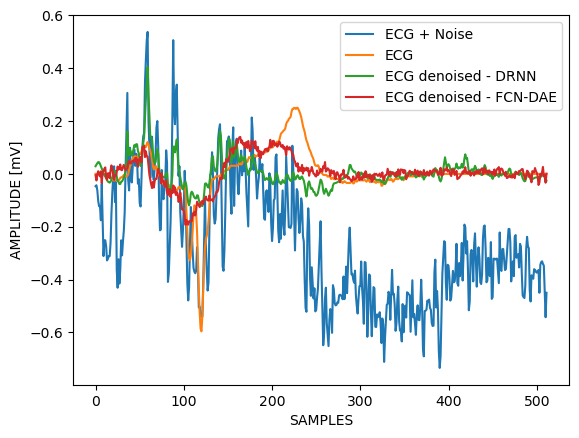

10783


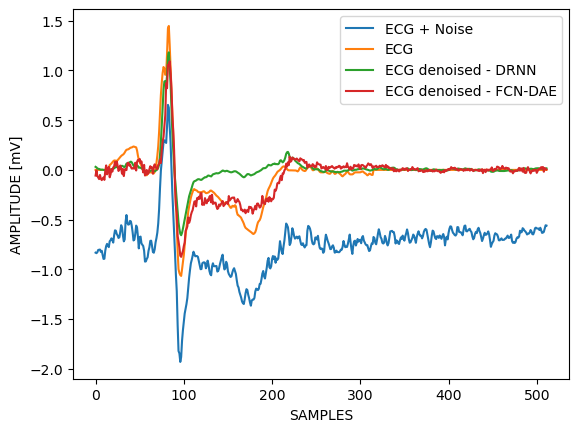

8231


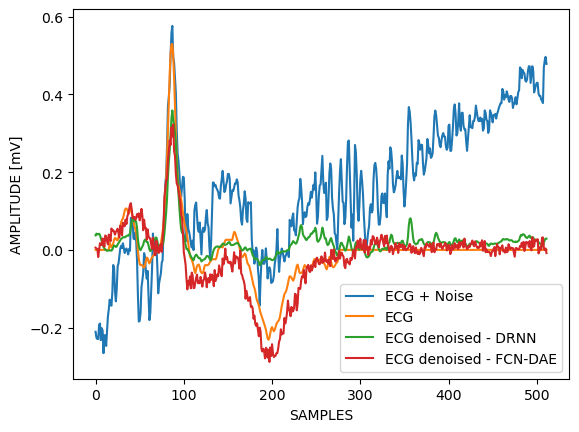

11318


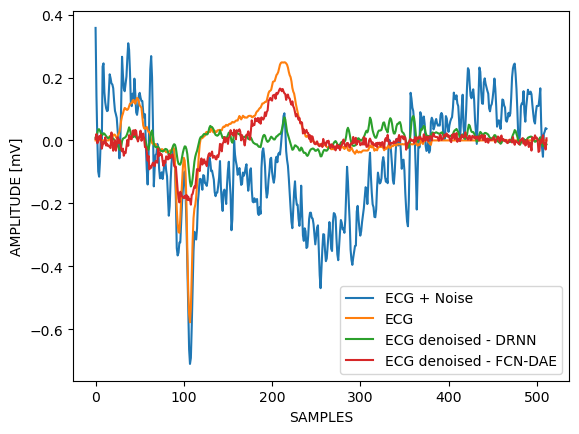

8376


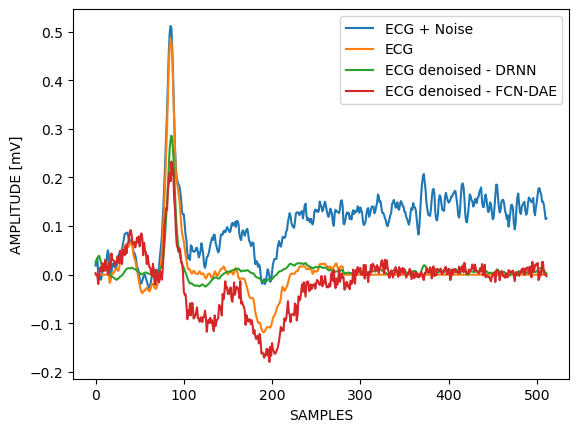

11635


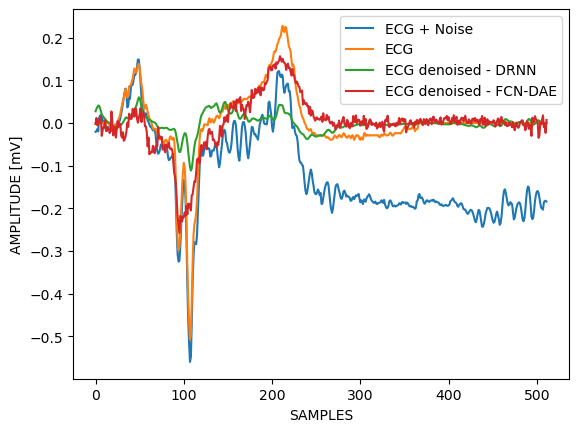

8355


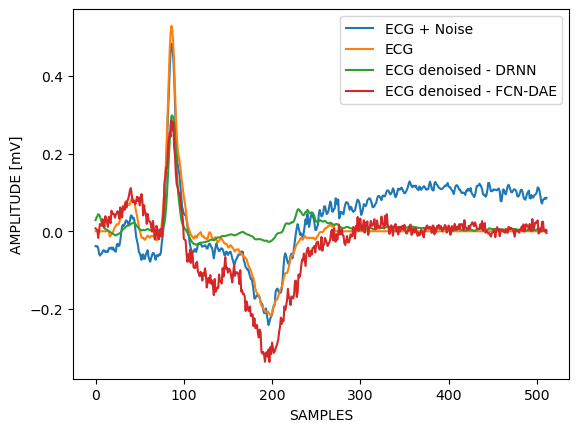

12859


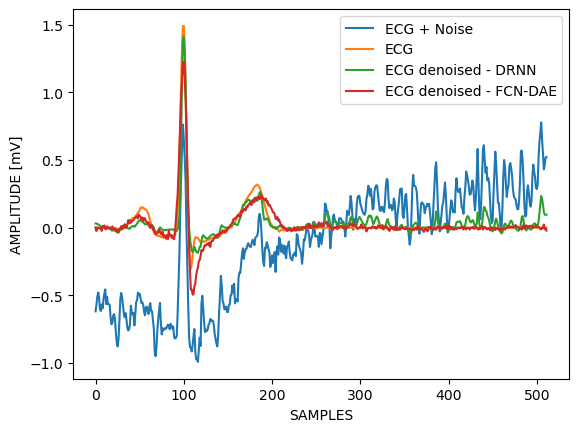

5846


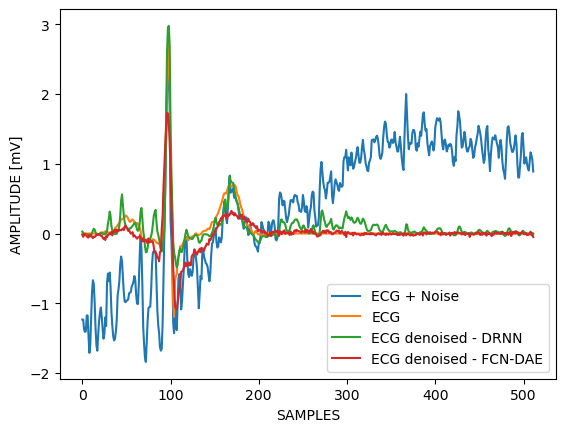

3093


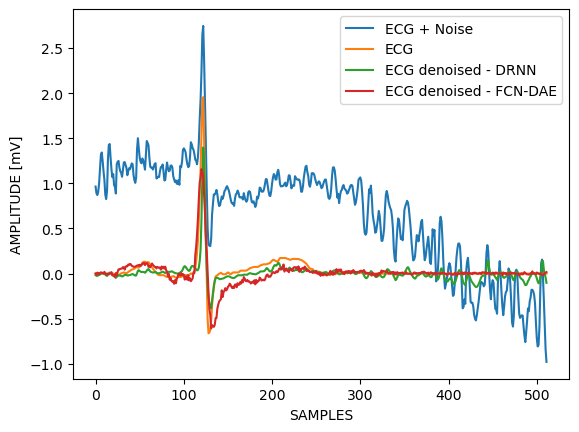

8439


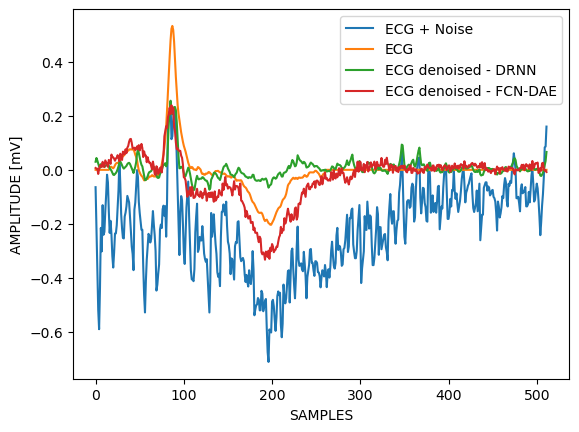

5901


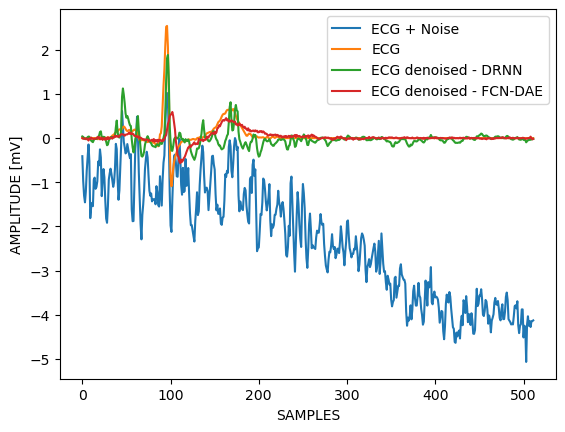

10357


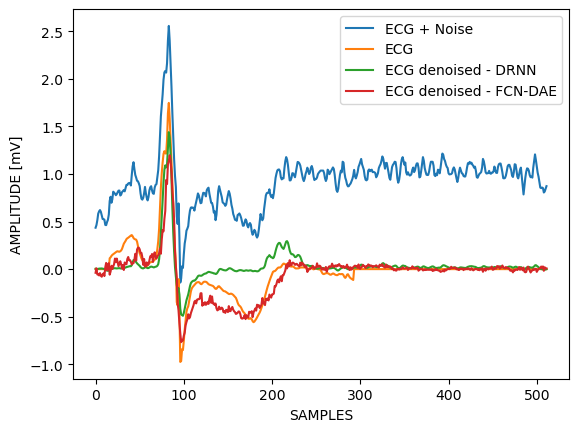

11022


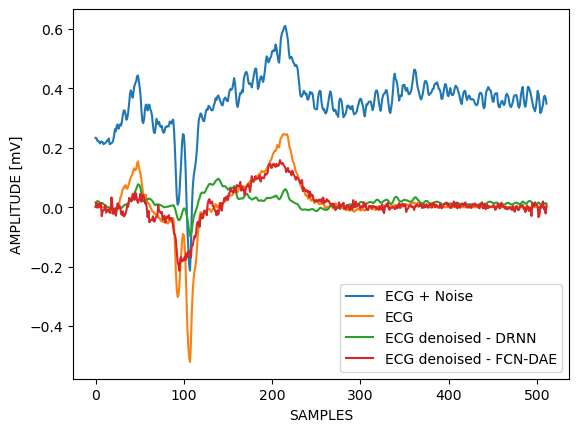

1679


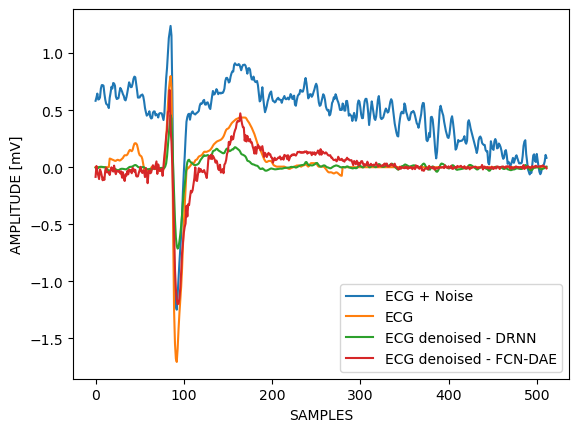

8508


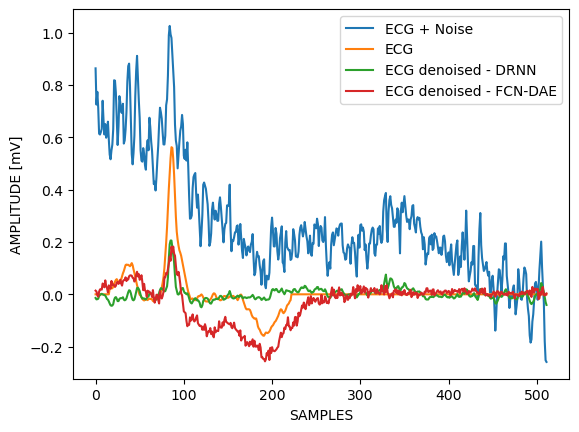

12211


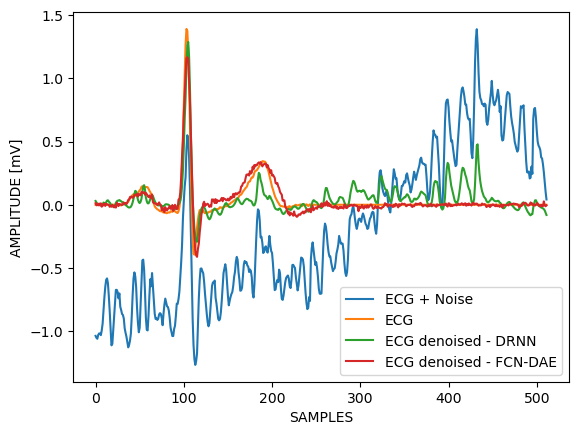

8014


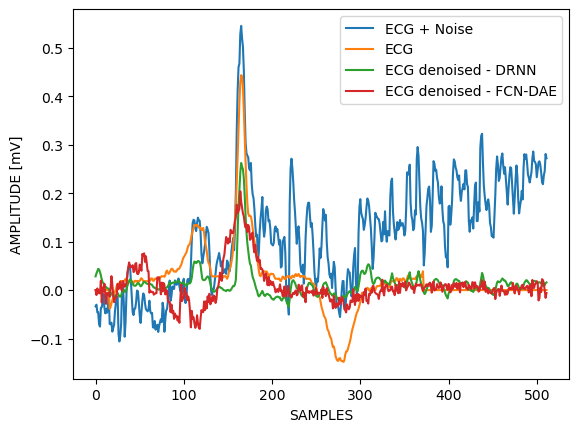

2500


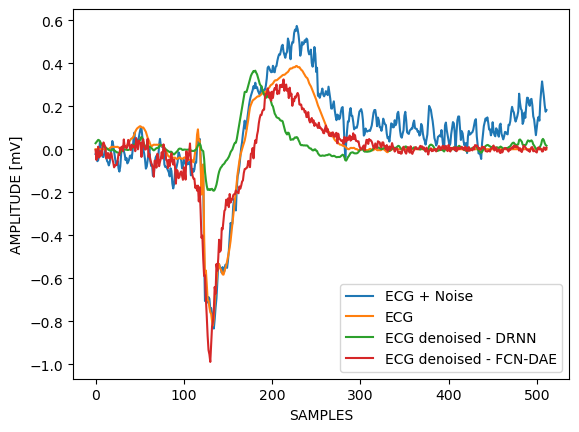

758


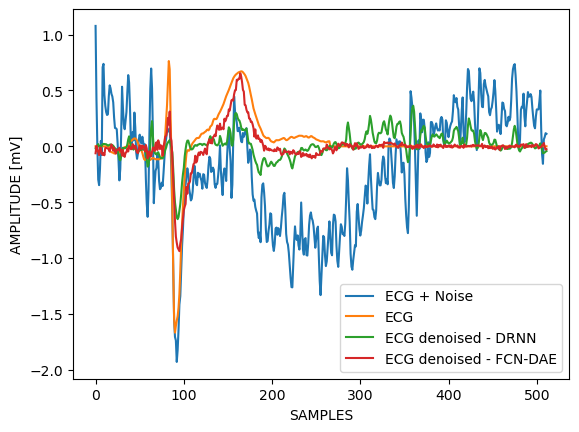

989


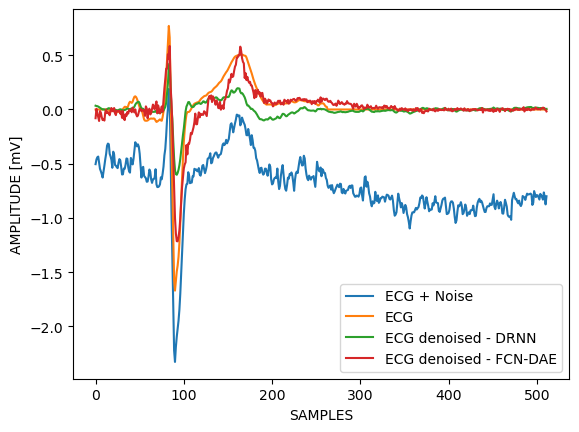

9513


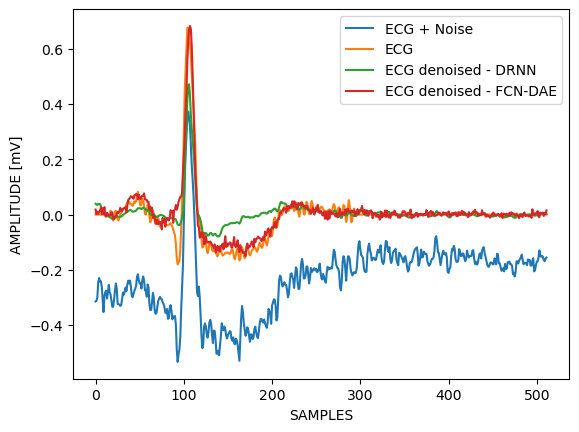

429


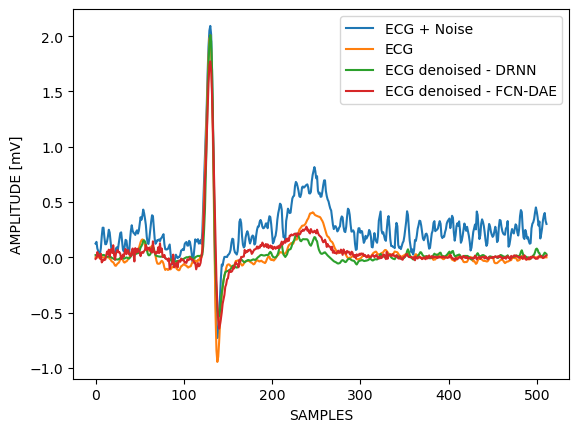

7613


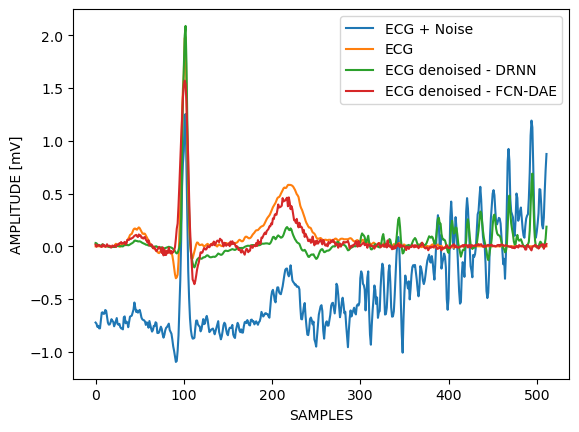

9661


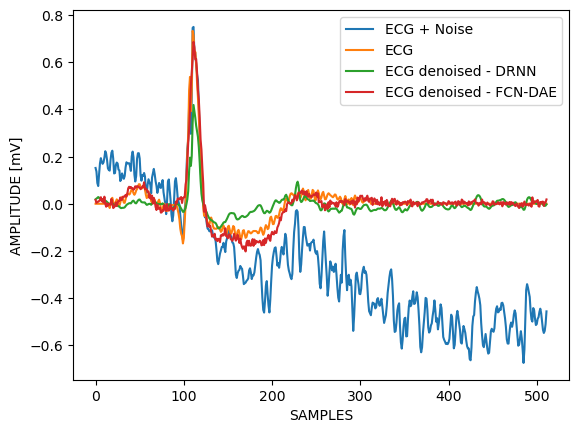

5682


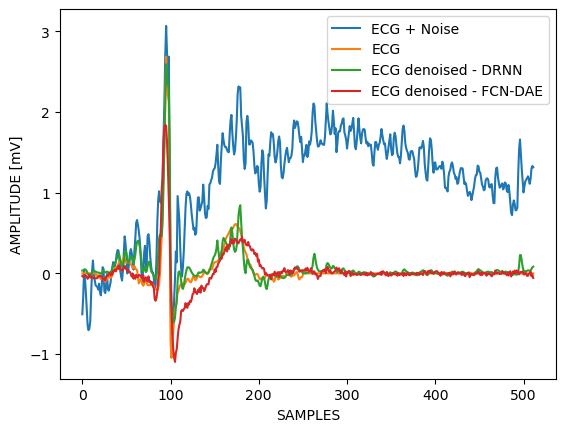

In [23]:
for x in np.random.randint(13000, size=50):
    print(x)
    plt.plot(X_test_1[x], label="ECG + Noise")
    plt.plot(y_test_1[x], label="ECG")
    plt.plot(y_pred_1[x], label="ECG denoised - DRNN")
    plt.plot(y_pred_2[x], label="ECG denoised - FCN-DAE")
    plt.xlabel("SAMPLES")
    plt.ylabel("AMPLITUDE [mV]")
    plt.legend()
    plt.show()

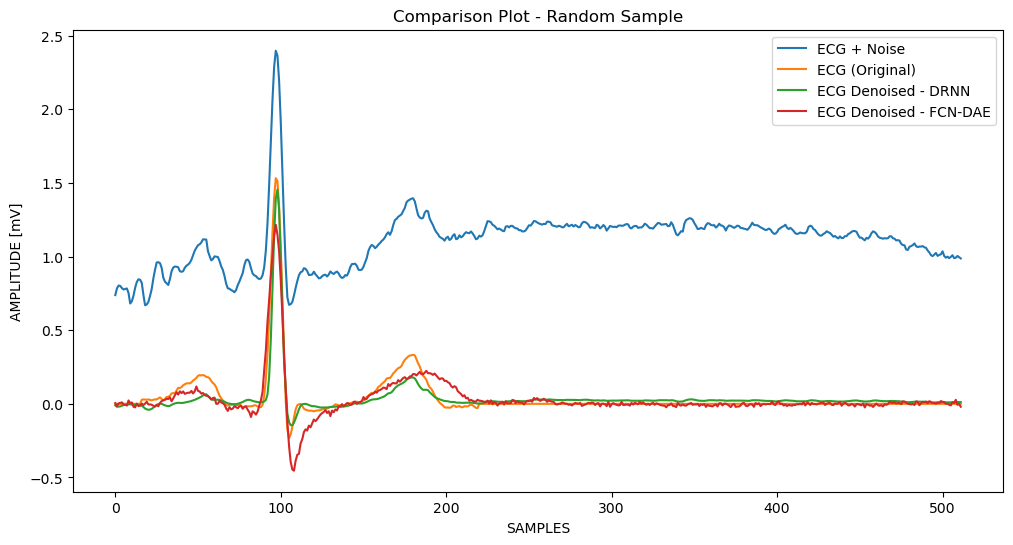

In [24]:
# Choose a random index
sample_index = np.random.randint(len(X_test_1))

# Plot the signals
plt.figure(figsize=(12, 6))
plt.plot(X_test_1[sample_index], label="ECG + Noise")
plt.plot(y_test_1[sample_index], label="ECG (Original)")
plt.plot(y_pred_1[sample_index], label="ECG Denoised - DRNN")
plt.plot(y_pred_2[sample_index], label="ECG Denoised - FCN-DAE")
plt.xlabel("SAMPLES")
plt.ylabel("AMPLITUDE [mV]")
plt.legend()
plt.title("Comparison Plot - Random Sample")
plt.show()


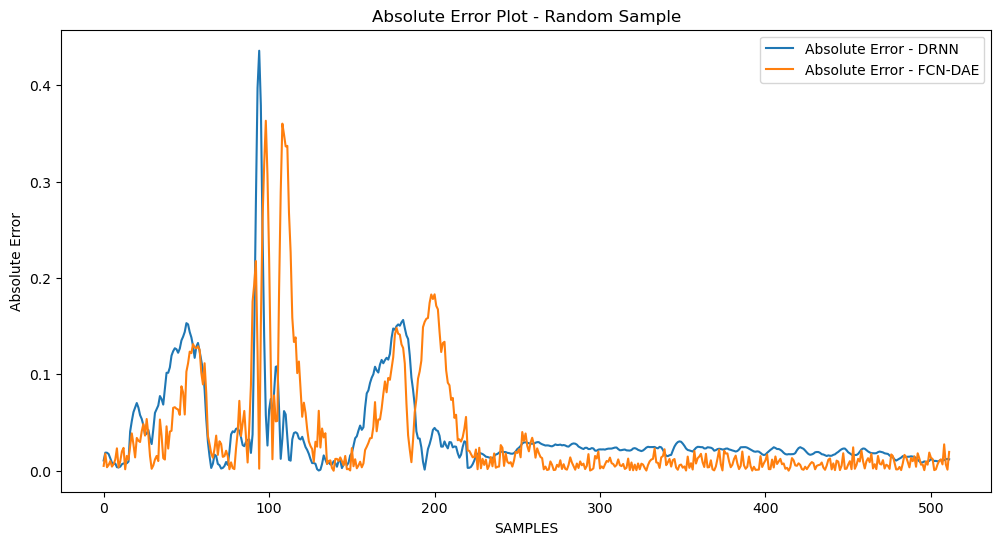

In [26]:
# Calculate absolute errors
abs_errors_DRNN = np.abs(y_test_1 - y_pred_1)
abs_errors_FCN_DAE = np.abs(y_test_1 - y_pred_2)

# Plot the errors
plt.figure(figsize=(12, 6))
plt.plot(abs_errors_DRNN[sample_index], label="Absolute Error - DRNN")
plt.plot(abs_errors_FCN_DAE[sample_index], label="Absolute Error - FCN-DAE")
plt.xlabel("SAMPLES")
plt.ylabel("Absolute Error")
plt.legend()
plt.title("Absolute Error Plot - Random Sample")
plt.show()


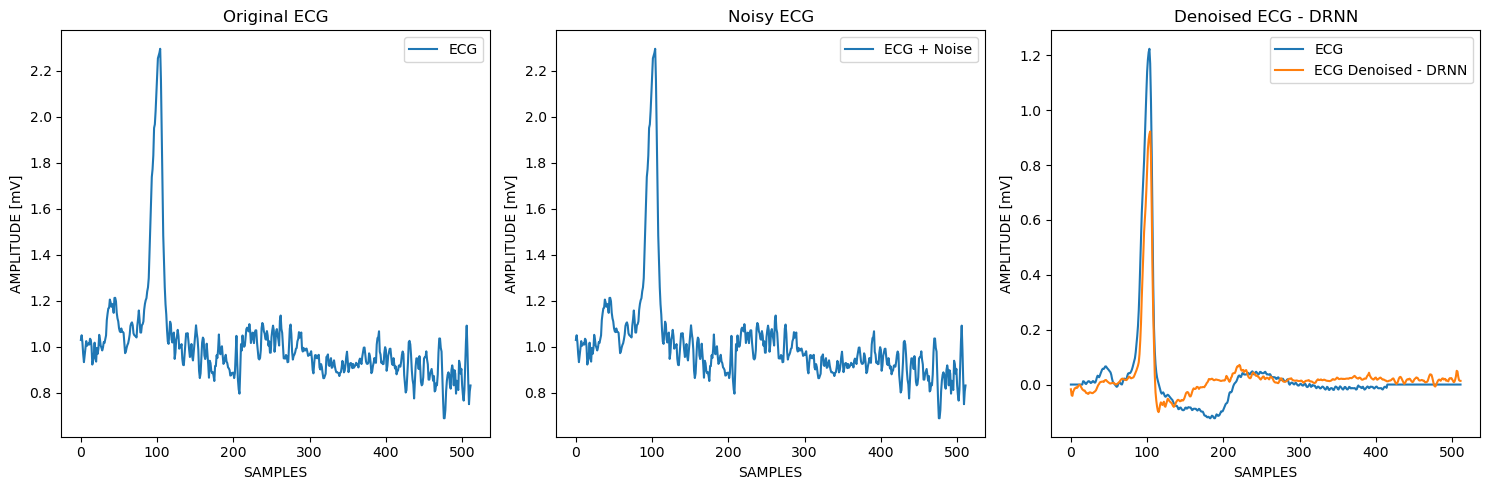

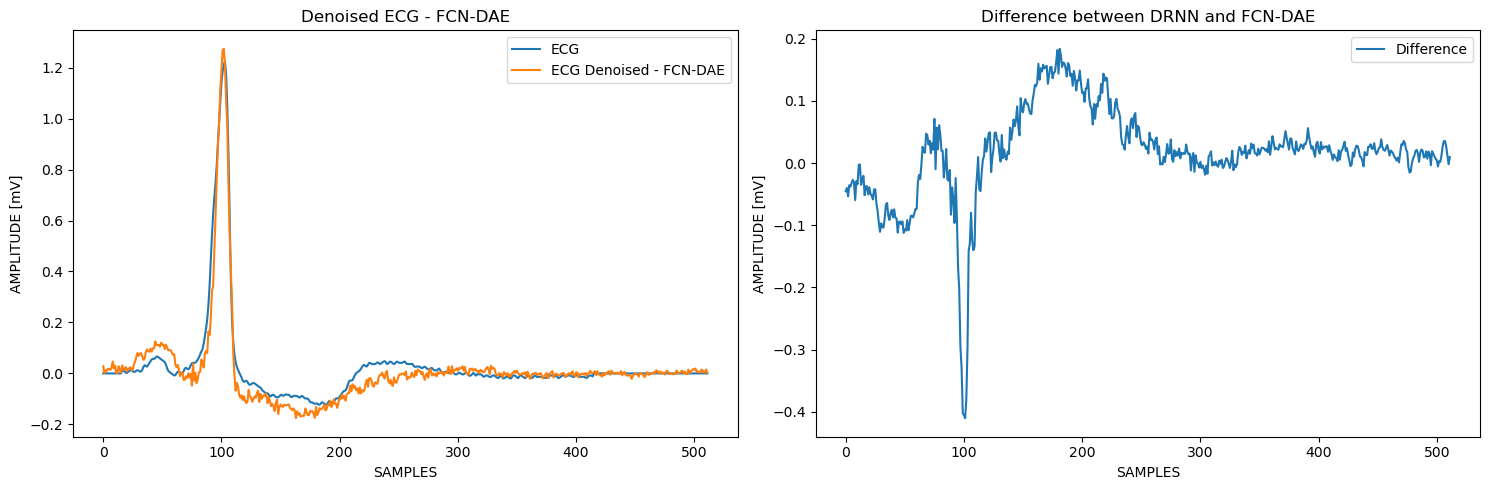

In [31]:
# Plot random samples
for x in np.random.randint(len(X_test_1), size=1):
    plt.figure(figsize=(15, 5))

    # Original ECG
    plt.subplot(1, 3, 1)
    plt.plot(X_test_1[x], label="ECG")
    plt.title("Original ECG")
    plt.xlabel("SAMPLES")
    plt.ylabel("AMPLITUDE [mV]")
    plt.legend()

    # Noisy ECG
    plt.subplot(1, 3, 2)
    plt.plot(X_test_1[x], label="ECG + Noise")
    plt.title("Noisy ECG")
    plt.xlabel("SAMPLES")
    plt.ylabel("AMPLITUDE [mV]")
    plt.legend()

    # Denoised ECG - DRNN
    plt.subplot(1, 3, 3)
    plt.plot(y_test_1[x], label="ECG")
    plt.plot(y_pred_1[x], label="ECG Denoised - DRNN")
    plt.title("Denoised ECG - DRNN")
    plt.xlabel("SAMPLES")
    plt.ylabel("AMPLITUDE [mV]")
    plt.legend()

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 5))

    # Denoised ECG - FCN-DAE
    plt.subplot(1, 2, 1)
    plt.plot(y_test_2[x], label="ECG")
    plt.plot(y_pred_2[x], label="ECG Denoised - FCN-DAE")
    plt.title("Denoised ECG - FCN-DAE")
    plt.xlabel("SAMPLES")
    plt.ylabel("AMPLITUDE [mV]")
    plt.legend()

    # Difference between DRNN and FCN-DAE
    plt.subplot(1, 2, 2)
    plt.plot(y_pred_1[x] - y_pred_2[x], label="Difference")
    plt.title("Difference between DRNN and FCN-DAE")
    plt.xlabel("SAMPLES")
    plt.ylabel("AMPLITUDE [mV]")
    plt.legend()

    plt.tight_layout()
    plt.show()
